In [25]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [26]:
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange',
    'CRISPR-cas9': 'tab:orange',
    'drug': 'tab:green',
    'cytokine': 'tab:olive'
}

# Load Data

In [27]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']
print(len(h5_files))
list(h5_files.keys())

35


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'GehringPachter2019',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissman2016_GSM2406675_10X001',
 'SrivatsanTrapnell2020_sciplex2

In [28]:
# capture obs and vars in a dict, indices as keis
obses = {}
vares = {}
for name, path in tqdm(h5_files.items(), leave=False):
    obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
    vares[name] = pd.read_csv(os.path.dirname(path)+'/var.csv')


In [29]:
# This is our ecsel table on the datasets
metadata = pd.read_csv('../../tables/publicly_available_singlecell_perturbation_data_25072022.csv', index_col=0)
metadata.keys()

Index(['Title', 'doi/url', 'First author', 'Selected other authors',
       'Corresponding Emails', 'Organisms', 'Modality = Data type', 'Method',
       'Sequencer', 'Library construction', 'data access', 'GSE', 'Tissues',
       'Perturbation', 'Leukemia', 'Solid Cancer', 'Notes',
       '# samples, cells or runs', 'multiple time points?',
       'multiple concentrations?', 'combined perturbations?',
       'Date of Submission', 'sgRNA library', 'Download status',
       'Mini-Abstract (loosely summarized original Abstract)'],
      dtype='object')

# Overview over existing annotations

## which dataset has wich obs columns?

In [5]:
# queri which annotations ecsist for which dataset
A = pd.DataFrame(columns=pd.unique(np.sum([list(obses[key].columns) for key in obses.keys()])))
for name, obs in obses.items():
    A.loc[name] = [x in obs.columns for x in A.columns]
A

,Unnamed: 0,perturbation,hto,guide_id,hto_barcode,gdo_barcode,tissue_type,cell_line,cancer,disease,...,well,plate,pathway_level_1,pathway_level_2,pathway,hash_UMI_counts,plate_id,well_id,sgRNA_read_count,sgRNA_umi_count
PapalexiSatija2021_eccite_arrayed_RNA,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
PapalexiSatija2021_eccite_RNA,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
TianKampmann2021_CRISPRa,True,True,False,True,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
TianKampmann2021_CRISPRi,True,True,False,True,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
XieHon2017,True,True,False,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
AissaBenevolenskaya2021,False,True,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
McFarlandTshemiak2020_all_expts_combined,True,True,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
GasperiniShendure2019_lowMOI,False,True,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
GasperiniShendure2019_atscale,True,True,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
GasperiniShendure2019_highMOI,True,True,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


## export drug names for mapping

In [38]:
druggies = ['McFarlandTshemiak2020_all_expts_combined', 'SrivatsanTrapnell2020_sciplex2',
 'SrivatsanTrapnell2020_sciplex3', 'SrivatsanTrapnell2020_sciplex4', 'ZhaoSims2021', 'ChangYe2021', 'GehringPachter2019', 'AissaBenevolenskaya2021']

In [110]:
data = []
for ds in druggies:
    drugs = list(pd.unique(obses[ds].perturbation))
    for drug in drugs:
        data.append([drug, ds])
tab = pd.DataFrame(data, columns=['original_drugname', 'dataset'])
tab = tab[tab.original_drugname!='control']
tab = tab[~pd.isna(tab.original_drugname)]
# remove crisprs
tab = tab[~tab.original_drugname.str.startswith('sg').fillna(False)].reset_index(drop=True)

In [111]:
tab.to_csv('../../tables/drugnames_raw.csv')

# Cell-wise metadata (Obs)

- number of genes expressed
- number of counts in total
- percent mito (dead cells)
- percent ribo (translational activity?)
- percent hemo (blood, only in primary tissue)

In [9]:
cat_obs_keys = ['perturbation_type', 'organism', 'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype']  # cat vector with a single value (ideally)

# sort
obses = {key: obses[key] for key in np.sort(list(obses.keys()))} 

B=pd.DataFrame({name: [list(pd.unique(obs[key]))[0] if key in obs.keys() else None for key in cat_obs_keys] for name, obs in obses.items()}, index=cat_obs_keys).T

B.loc['XieHon2017', 'celltype'] = 'lymphoblasts'
B.loc['McFarlandTshemiak2020_all_expts_combined', 'celltype'] = 'lymphoblasts'
B.loc['WeinrebKlein2020', 'celltype'] = 'lymphoblasts'
B.loc['WeinrebKlein2020', 'cell_line'] = 'Mo'
B.loc['ChangYe2021', 'celltype'] = 'epithelial'
B.loc['FrangiehIzar2021_RNA', 'tissue_type'] = 'cell_line'
B.loc['ChangYe2021', 'tissue_type'] = 'cell_line'

B.celltype = B.celltype.replace({'iPSC-induced neuron': 'iPSC neurons', 'iPSC': 'iPSC neurons', 'alveolar basal epithelial cells': 'epithelial', 'mammary epithelial cells': 'epithelial'})
B.celltype = B.celltype.replace({'monocytes': 'mono- cytes', 'lymphoblasts': 'lympho- blasts', 'melanocytes': 'melano- cytes', 'epithelial': 'epi- thelial'})
B.disease = B.disease.replace({'acute monocytic leukemia': 'AMoL', 'myelogenous leukemia': 'AML', 'chronic myelogenous leukemia': 'CML', 'acute T cell leukemia': 'T-ALL',
                              'lung adenocarcinoma': 'lung AC', 'breast adenocarcinoma': 'breast AC'})
B.disease = B.disease.replace({'melanoma': 'mela- noma', 'glioblastoma': 'glio- blastoma'})

B.loc['TianKampmann2021_CRISPRa', 'perturbation_type'] = 'CRISPRa'
B.loc['TianKampmann2021_CRISPRi', 'perturbation_type'] = 'CRISPRi'
B.loc['TianKampmann2019_iPSC', 'perturbation_type'] = 'CRISPRi'
B.loc['TianKampmann2019_day7neuron', 'perturbation_type'] = 'CRISPRi'

# B=B.rename({'PapalexiSatija2021_eccite_arrayed_RNA' : 'PapalexiSatija2021_arrayed',
#                  'PapalexiSatija2021_eccite_RNA' : 'PapalexiSatija2021',
#                  'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTshemiak2020',
#                  'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen': 'SchraivogelSteinmetz2020_Chr11',
#                  'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen': 'SchraivogelSteinmetz2020_Chr8',
#                  'AdamsonWeissman2016_GSM2406677_10X005': 'AdamsonWeissman2016_10X005',
#                  'AdamsonWeissman2016_GSM2406681_10X010': 'AdamsonWeissman2016_10X010',
#                  'AdamsonWeissman2016_GSM2406675_10X001': 'AdamsonWeissman2016_10X001'
#                 })
                
B.head()

,perturbation_type,organism,tissue_type,cell_line,cancer,disease,celltype
AdamsonWeissman2016_GSM2406675_10X001,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AdamsonWeissman2016_GSM2406677_10X005,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AdamsonWeissman2016_GSM2406681_10X010,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AissaBenevolenskaya2021,drug,human,cell_line,PC9_xenograft,True,NaN,NaN
ChangYe2021,drug,human,cell_line,None,True,lung AC,epi- thelial


## DEPRECATED cat scalar (e.g. metadata columns where each dataset has a categorical value such as cancer y/n). This is better summarized by pie plots.

In [112]:
cat_obs_keys = ['perturbation_type', 'organism', 'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype']  # cat vector with a single value (ideally)

In [113]:
# sort
obses = {key: obses[key] for key in np.sort(list(obses.keys()))} 

In [114]:
B=pd.DataFrame({name: [list(pd.unique(obs[key]))[0] if key in obs.keys() else None for key in cat_obs_keys] for name, obs in obses.items()}, index=cat_obs_keys).T

B.loc['XieHon2017', 'celltype'] = 'lymphoblasts'
B.loc['McFarlandTshemiak2020_all_expts_combined', 'celltype'] = 'lymphoblasts'
B.loc['WeinrebKlein2020', 'celltype'] = 'lymphoblasts'
B.loc['WeinrebKlein2020', 'cell_line'] = 'Mo'
B.loc['ChangYe2021', 'celltype'] = 'epithelial'
B.loc['FrangiehIzar2021_RNA', 'tissue_type'] = 'cell_line'
B.loc['ChangYe2021', 'tissue_type'] = 'cell_line'

B.celltype = B.celltype.replace({'iPSC-induced neuron': 'iPSC neurons', 'iPSC': 'iPSC neurons', 'alveolar basal epithelial cells': 'epithelial', 'mammary epithelial cells': 'epithelial'})
B.celltype = B.celltype.replace({'monocytes': 'mono- cytes', 'lymphoblasts': 'lympho- blasts', 'melanocytes': 'melano- cytes', 'epithelial': 'epi- thelial'})
B.disease = B.disease.replace({'acute monocytic leukemia': 'AMoL', 'myelogenous leukemia': 'AML', 'chronic myelogenous leukemia': 'CML', 'acute T cell leukemia': 'T-ALL',
                              'lung adenocarcinoma': 'lung AC', 'breast adenocarcinoma': 'breast AC'})
B.disease = B.disease.replace({'melanoma': 'mela- noma', 'glioblastoma': 'glio- blastoma'})

B=B.rename({'PapalexiSatija2021_eccite_arrayed_RNA' : 'PapalexiSatija2021_arrayed',
                 'PapalexiSatija2021_eccite_RNA' : 'PapalexiSatija2021',
                 'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTshemiak2020',
                 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen': 'SchraivogelSteinmetz2020_Chr11',
                 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen': 'SchraivogelSteinmetz2020_Chr8',
                 'AdamsonWeissman2016_GSM2406677_10X005': 'AdamsonWeissman2016_10X005',
                 'AdamsonWeissman2016_GSM2406681_10X010': 'AdamsonWeissman2016_10X010',
                 'AdamsonWeissman2016_GSM2406675_10X001': 'AdamsonWeissman2016_10X001'
                })
                
B

,perturbation_type,organism,tissue_type,cell_line,cancer,disease,celltype
AdamsonWeissman2016_10X001,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AdamsonWeissman2016_10X005,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AdamsonWeissman2016_10X010,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AissaBenevolenskaya2021,drug,human,cell_line,PC9_xenograft,True,NaN,NaN
ChangYe2021,drug,human,cell_line,None,True,lung AC,epi- thelial
DatlingerBock2017,CRISPR,human,cell_line,Jurkat cells,True,T-ALL,T cells
DatlingerBock2021,CRISPR,human,cell_line,Jurkat cells,True,T-ALL,T cells
DixitRegev2016,CRISPR,None,None,K562,True,AML,lympho- blasts
FrangiehIzar2021_RNA,CRISPR,human,cell_line,None,True,mela- noma,melano- cytes
GasperiniShendure2019_atscale,CRISPR,human,cell_line,K562,True,CML,lympho- blasts


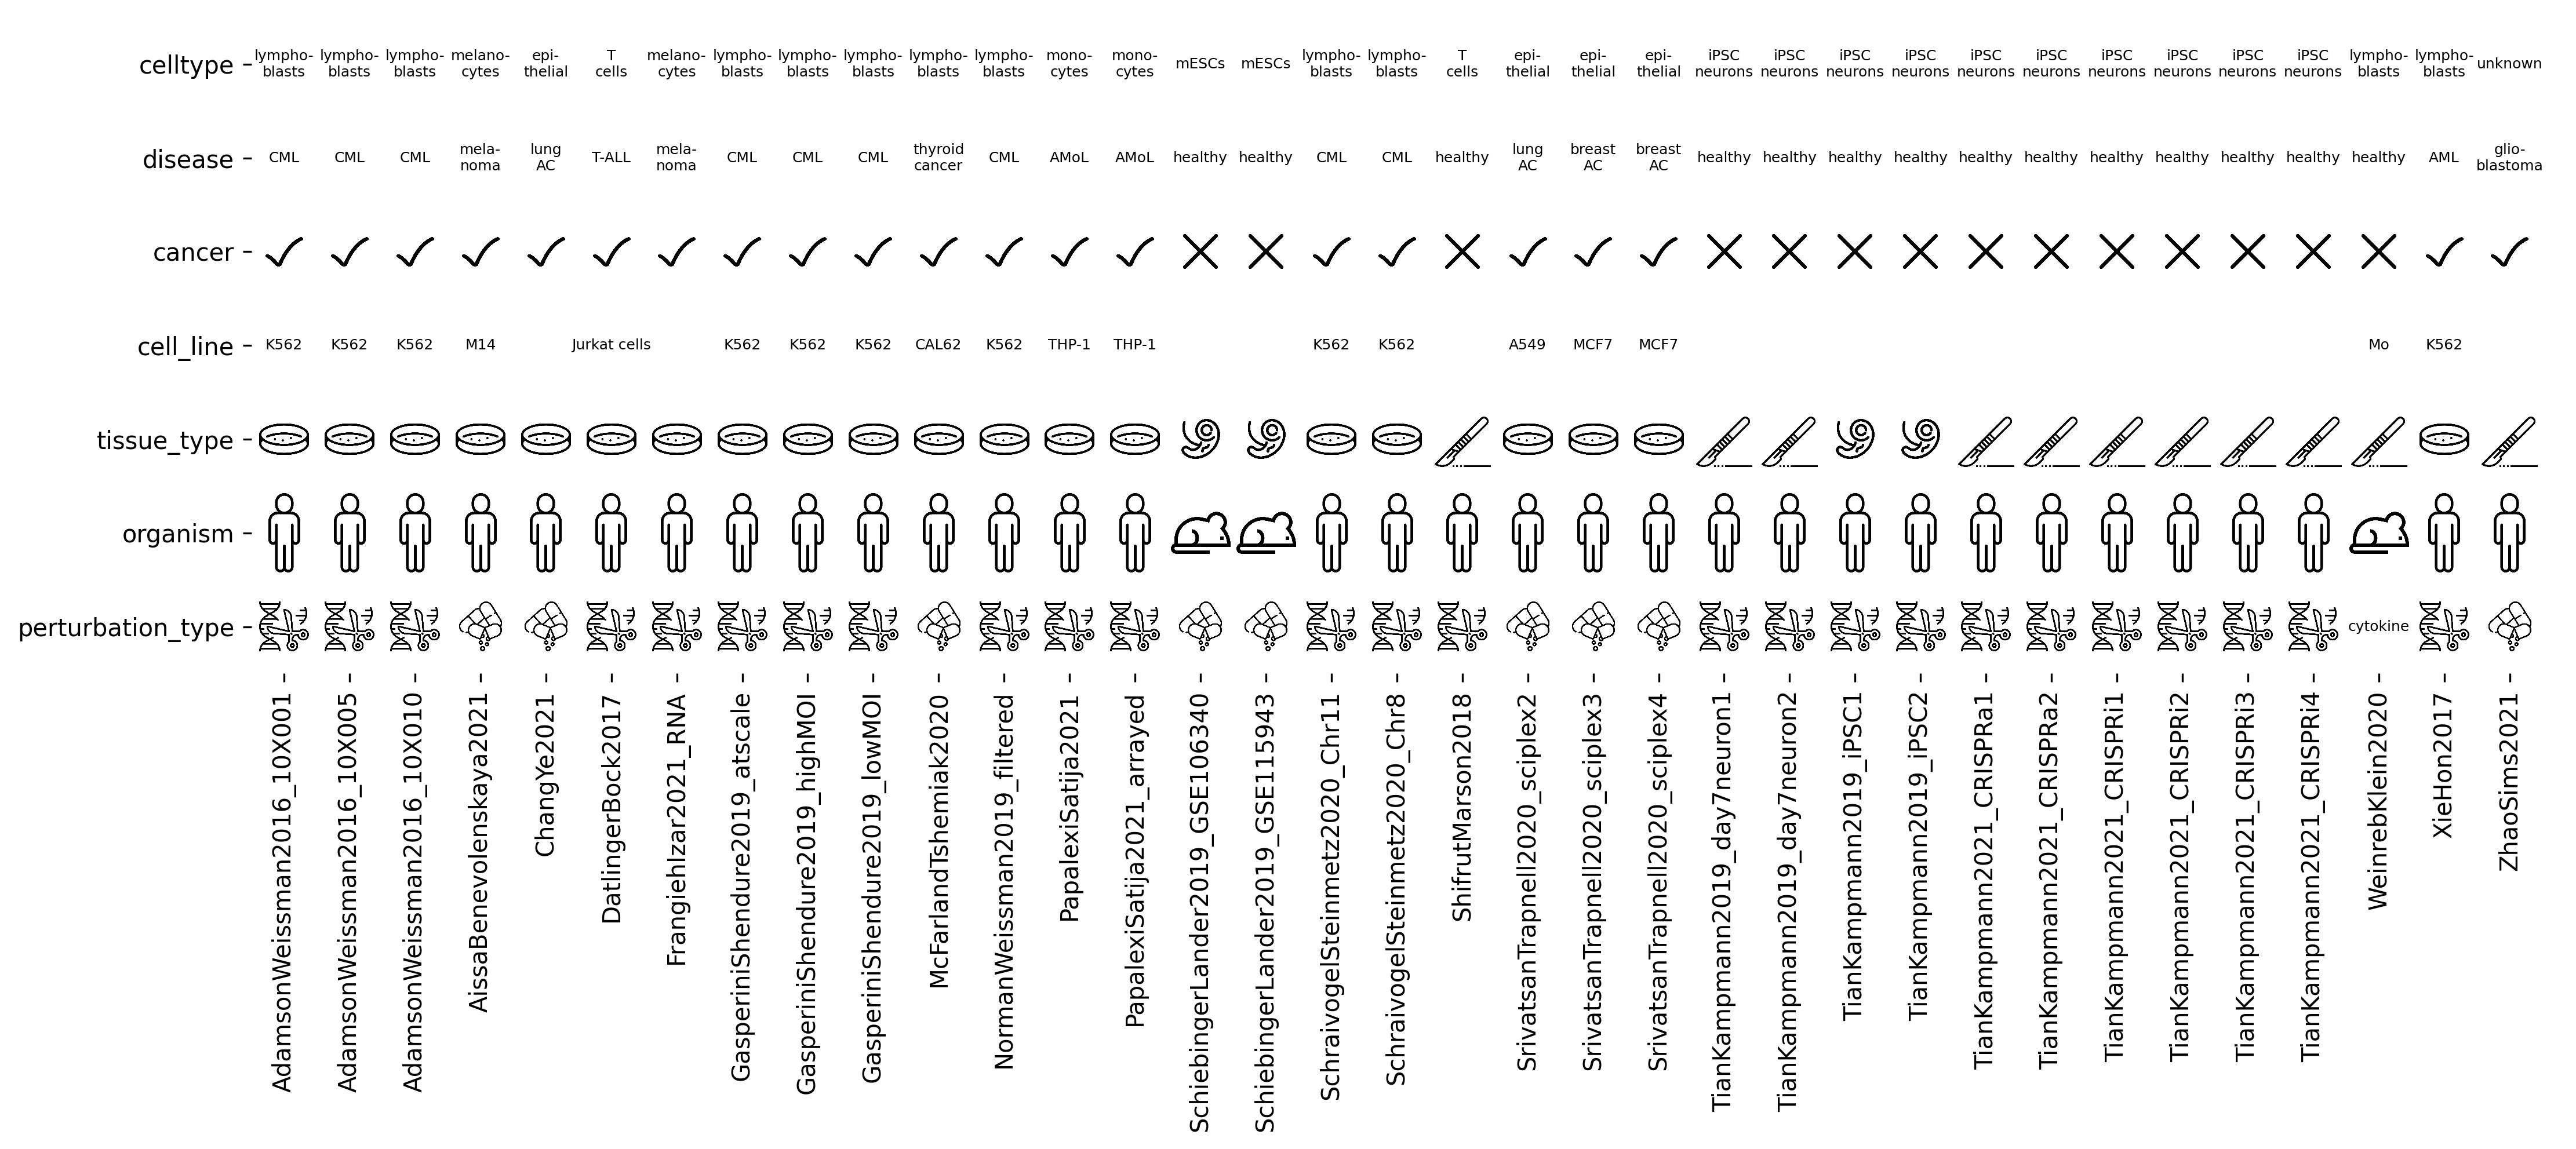

In [92]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

n = len(B.index)
m = len(B.columns)

fig, ax = pl.subplots(figsize=[17,5], dpi=300)
text_options = {'fontsize': 6, 'ha': 'center', 'va': 'center'}

zoom_factor=0.8
mouse = OffsetImage(mpimg.imread('icons/mouse.png'), zoom=0.06*zoom_factor)
stem = OffsetImage(mpimg.imread('icons/stem.png'), zoom=0.04*zoom_factor)
human = OffsetImage(mpimg.imread('icons/person-standing.png'), zoom=0.08*zoom_factor)
primary = OffsetImage(mpimg.imread('icons/scalpel.png'), zoom=0.06*zoom_factor)
cell_line = OffsetImage(mpimg.imread('icons/petri-dish.png'), zoom=0.05*zoom_factor)
CRISPR = OffsetImage(mpimg.imread('icons/gene.png'), zoom=0.05*zoom_factor)
drug = OffsetImage(mpimg.imread('icons/pills.png'), zoom=0.05*zoom_factor)
True_ = OffsetImage(mpimg.imread('icons/check.png'), zoom=0.04*zoom_factor)
False_ = OffsetImage(mpimg.imread('icons/close.png'), zoom=0.035*zoom_factor)

# perturbation_type
for i, (index, row) in enumerate(B.iterrows()):
    # ax.text(i, 0, row.perturbation_type, **text_options)
    if row.perturbation_type=='cytokine':
        ax.text(i, 0, row.perturbation_type.replace('_', ''), **text_options)
    else:
        ax.add_artist(AnnotationBbox(eval(row.perturbation_type), (i, 0), frameon=False))
    
    ax.add_artist(AnnotationBbox(eval(row.organism), (i, 1), frameon=False))
    # ax.text(i, 2, row.tissue_type.replace('_', ''), **text_options)
    ax.add_artist(AnnotationBbox(eval(row.tissue_type), (i, 2), frameon=False))
    ax.text(i, 3, row.cell_line if row.cell_line!=None else '', **text_options)
    # ax.text(i, 4, 'yes' if row.cancer==True else 'no', **text_options)
    ax.add_artist(AnnotationBbox(eval(str(row.cancer)+'_'), (i, 4), frameon=False))
    ax.text(i, 5, row.disease.replace(' ', '\n'), **text_options)
    ax.text(i, 6, row.celltype.replace(' ', '\n') if row.celltype!=None else None, **text_options)

ax.set_xlim([-0.5, n-0.5])
ax.set_ylim([-0.5, m-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.get_xaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(m))
ax.set_xticklabels(B.index, rotation=90)
ax.set_yticklabels(B.columns)

pl.grid(False)
pl.savefig('../../figures/dataset_overview_icons.pdf', bbox_inches='tight')
pl.show()

## DEPRECATED cat vector


100%|██████████| 32/32 [07:24<00:00, 13.88s/it]


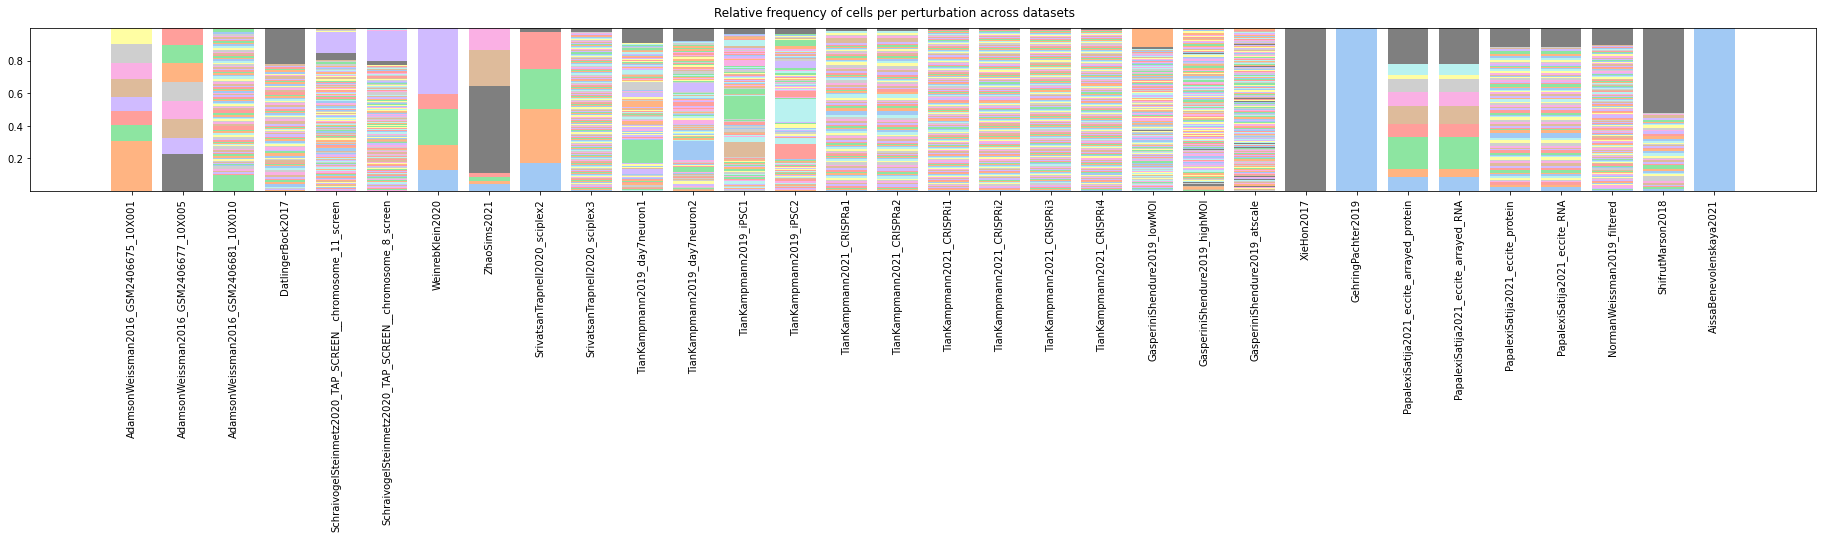

In [45]:
# takes 30mins!!!
cat_obs_keys = ['perturbation']  # cat vector
cat_data = []
for obs_key in cat_obs_keys:
    cat_data.append([obs[obs_key].values for obs in obses.values()])

fig, ax = pl.subplots(1, 1, figsize=[1*len(cat_data[0]), 3], sharex=True)
for i, dat in enumerate(tqdm(cat_data[0])):
    cats, abs_frqs = np.unique(dat[~pd.isna(dat)], return_counts=True)
    colors = sns.color_palette('pastel')[0:len(cats)]
    # if 'control' in cats: colors[np.where(cats=='control')[0][0]] = 'tab:grey'
    rel_frqs = abs_frqs / np.sum(abs_frqs)
    labels = [x if p>min_rel_frq else None for x, p in zip(cats, rel_frqs)]  # show labels if relative frequency is above 10%
    for height, bottom, j in zip(rel_frqs, [0] + list(np.cumsum(rel_frqs)), np.arange(len(rel_frqs))): 
        color = 'tab:grey' if ('ctrl' in cats[j]) or ('control' in cats[j]) else colors[j%len(colors)]
        pl.bar(i, height, bottom=bottom, color=color)
pl.suptitle('Relative frequency of cells per perturbation across datasets')
ax.set_xticks(np.arange(len(obses.keys())))
ax.set_xticklabels(list(obses.keys()), rotation=90)

pl.savefig('../../figures/dataset_overview_barplots.pdf', bbox_inches='tight')
pl.show()

## num vector (e.g. metadata columns where each cell in a dataset has a numerical value)

Brainstorming, ways how to display distributions of numerical values for many datasets:
- Violinplots or beanplots
- **Boxplots** (probably the way to go)
- Histograms (takes up too much space)

In [10]:
# TODO fix these datasets!
# delete datasets from obses where the column 'ncounts' is missing
K = list(obses.keys())
for name in K:
    if 'ncounts' not in obses[name].columns:
        print(name)
        del obses[name]

AissaBenevolenskaya2021
DixitRegev2016


In [11]:
# collect numerical data for cells per dataset
num_obs_keys = ['ncounts', 'ngenes', 'percent_mito', 'percent_ribo', # numerical vector
                'perturbation_type' # and annotations
               ]  
# for obs_key in num_obs_keys:
ddict = {name: obs[num_obs_keys] for name, obs in obses.items()}
df = pd.concat(ddict).reset_index(level=0)
df.columns = ['dataset'] + num_obs_keys

In [12]:
cpalette = {d: colors_perturbation_types[B.loc[d, 'perturbation_type']] for d in obses.keys()}

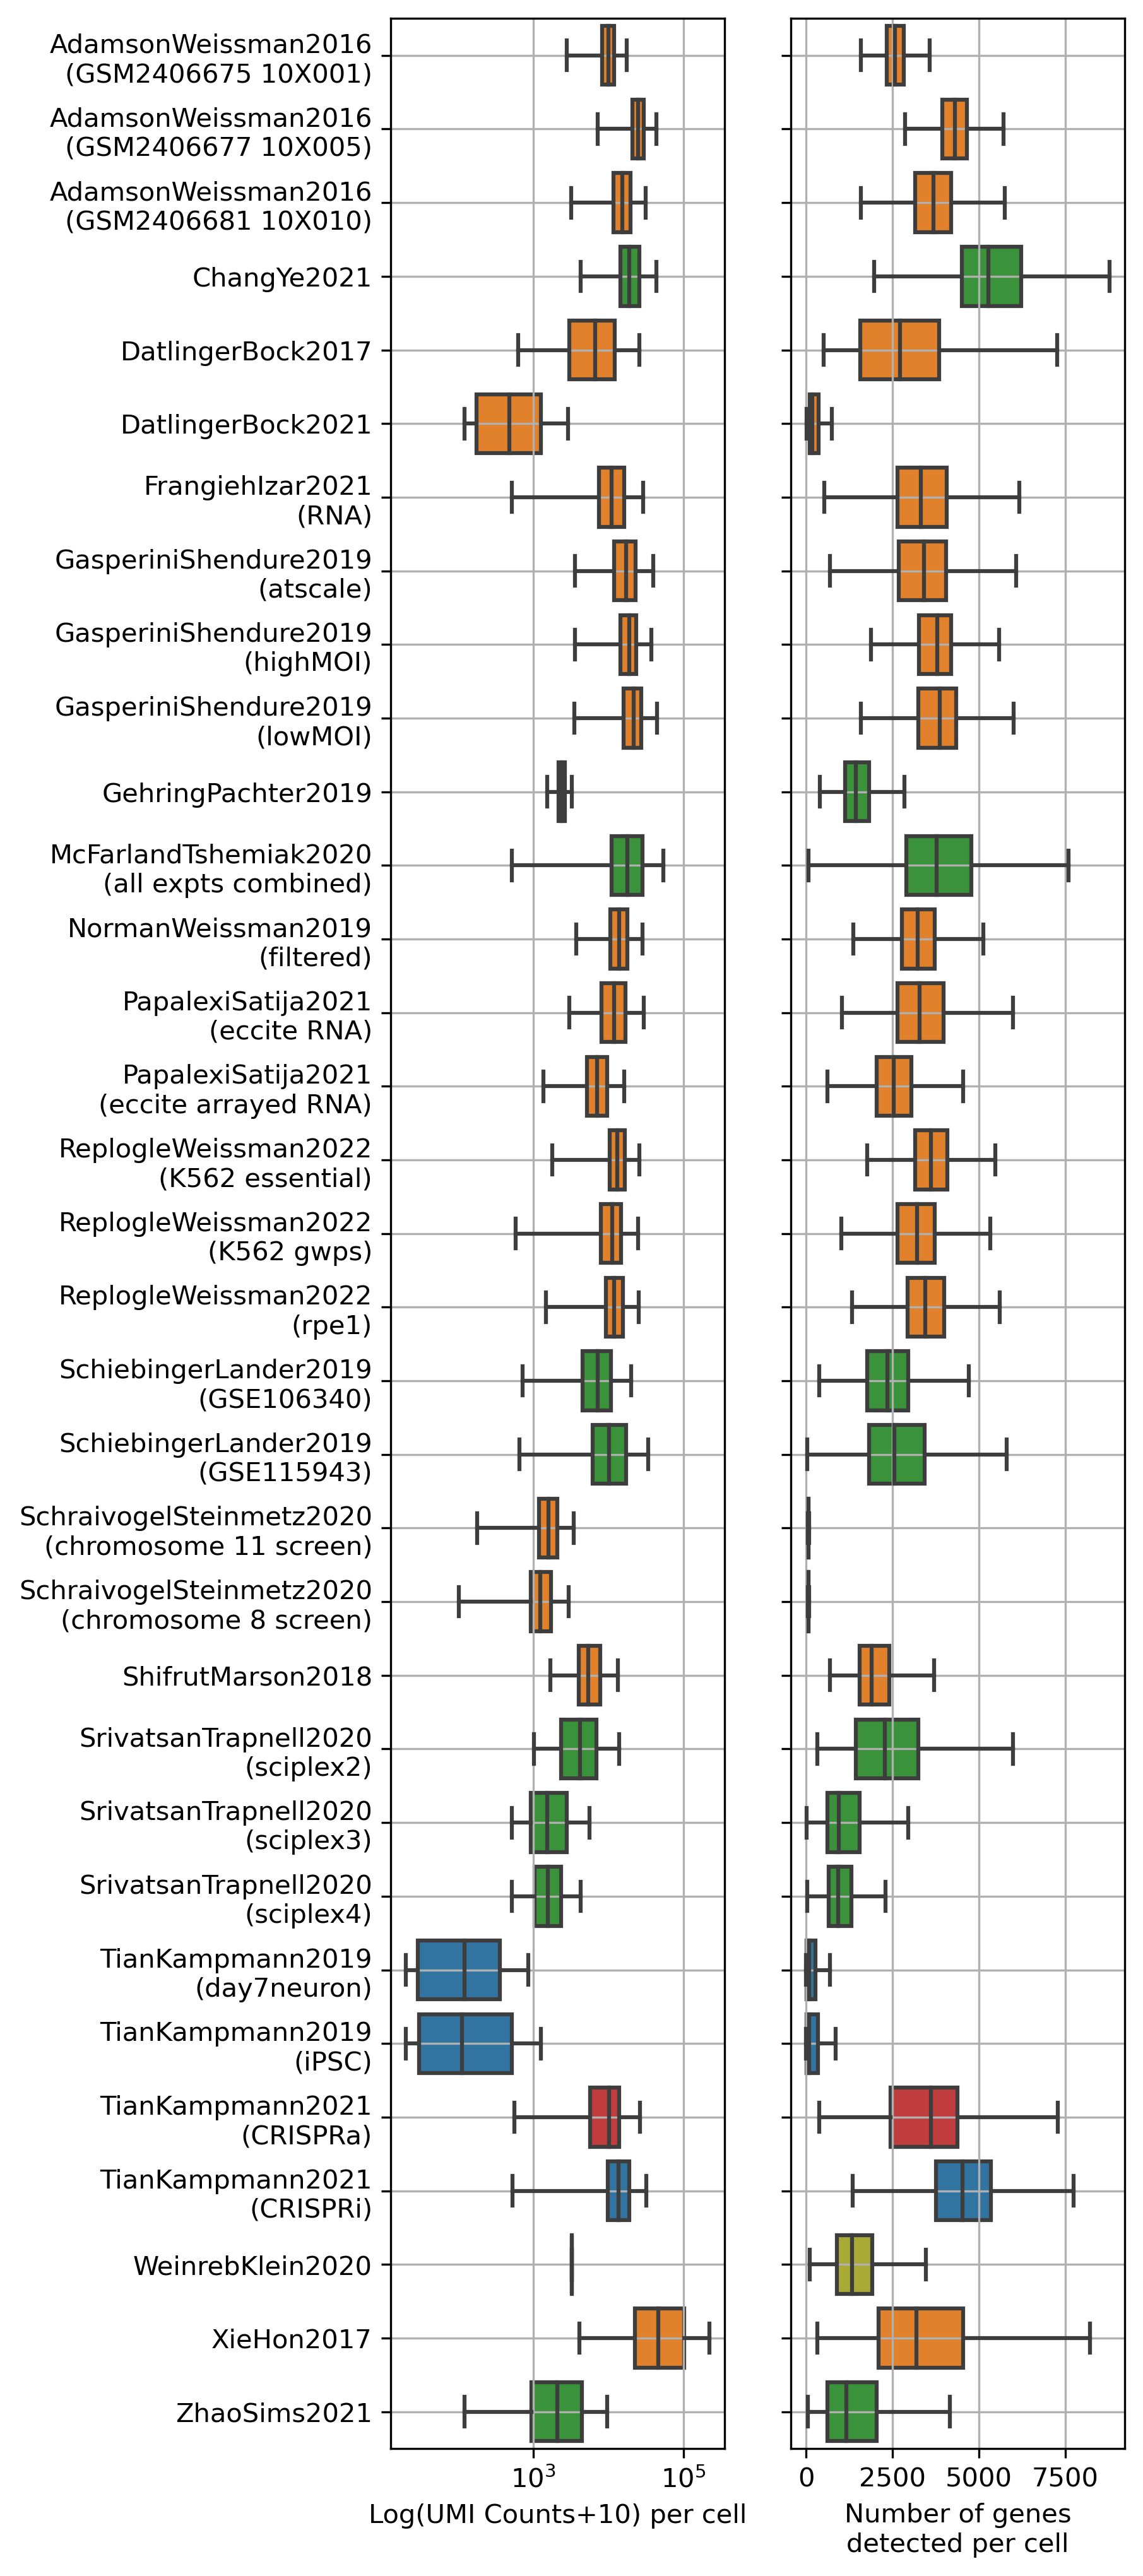

In [14]:
# options
color = 'perturbation_type'  #'tab:blue'
palette = cpalette
pseudocounts = 10

# setup figure
# with sns.axes_style("whitegrid"):
fig, axs = pl.subplots(1, 2, figsize=[5, 17], sharey=True, dpi=300)

# First row ncounts
ax = axs[0]
df['ncounts'] += pseudocounts
sns.boxplot(data=df, y='dataset', x='ncounts', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel(f'Log(UMI Counts+{pseudocounts}) per cell')
ax.set_xscale('log')
# ax.set_title('UMI Counts')
ax.grid()

# Second row ngenes
ax = axs[1]
sns.boxplot(data=df, y='dataset', x='ngenes', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel('Number of genes\ndetected per cell')
# ax.set_title('Genes Expressed')
ax.grid()
    
# xticks and labels
dataset_names = obses.keys()
dataset_names = [x.replace('TAP_SCREEN__', '') for x in dataset_names]
dataset_names = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in dataset_names]
dataset_names = [x.replace('_', ' ') for x in dataset_names]
axs[-1].set_yticks(np.arange(len(dataset_names)))
axs[-1].set_ylabel('')
axs[-1].set_yticklabels(dataset_names, rotation=90)
axs[0].set_ylabel('')
pl.savefig('../../figures/dataset_overview_boxplots_vertical.pdf', bbox_inches='tight')
pl.show()

## combined

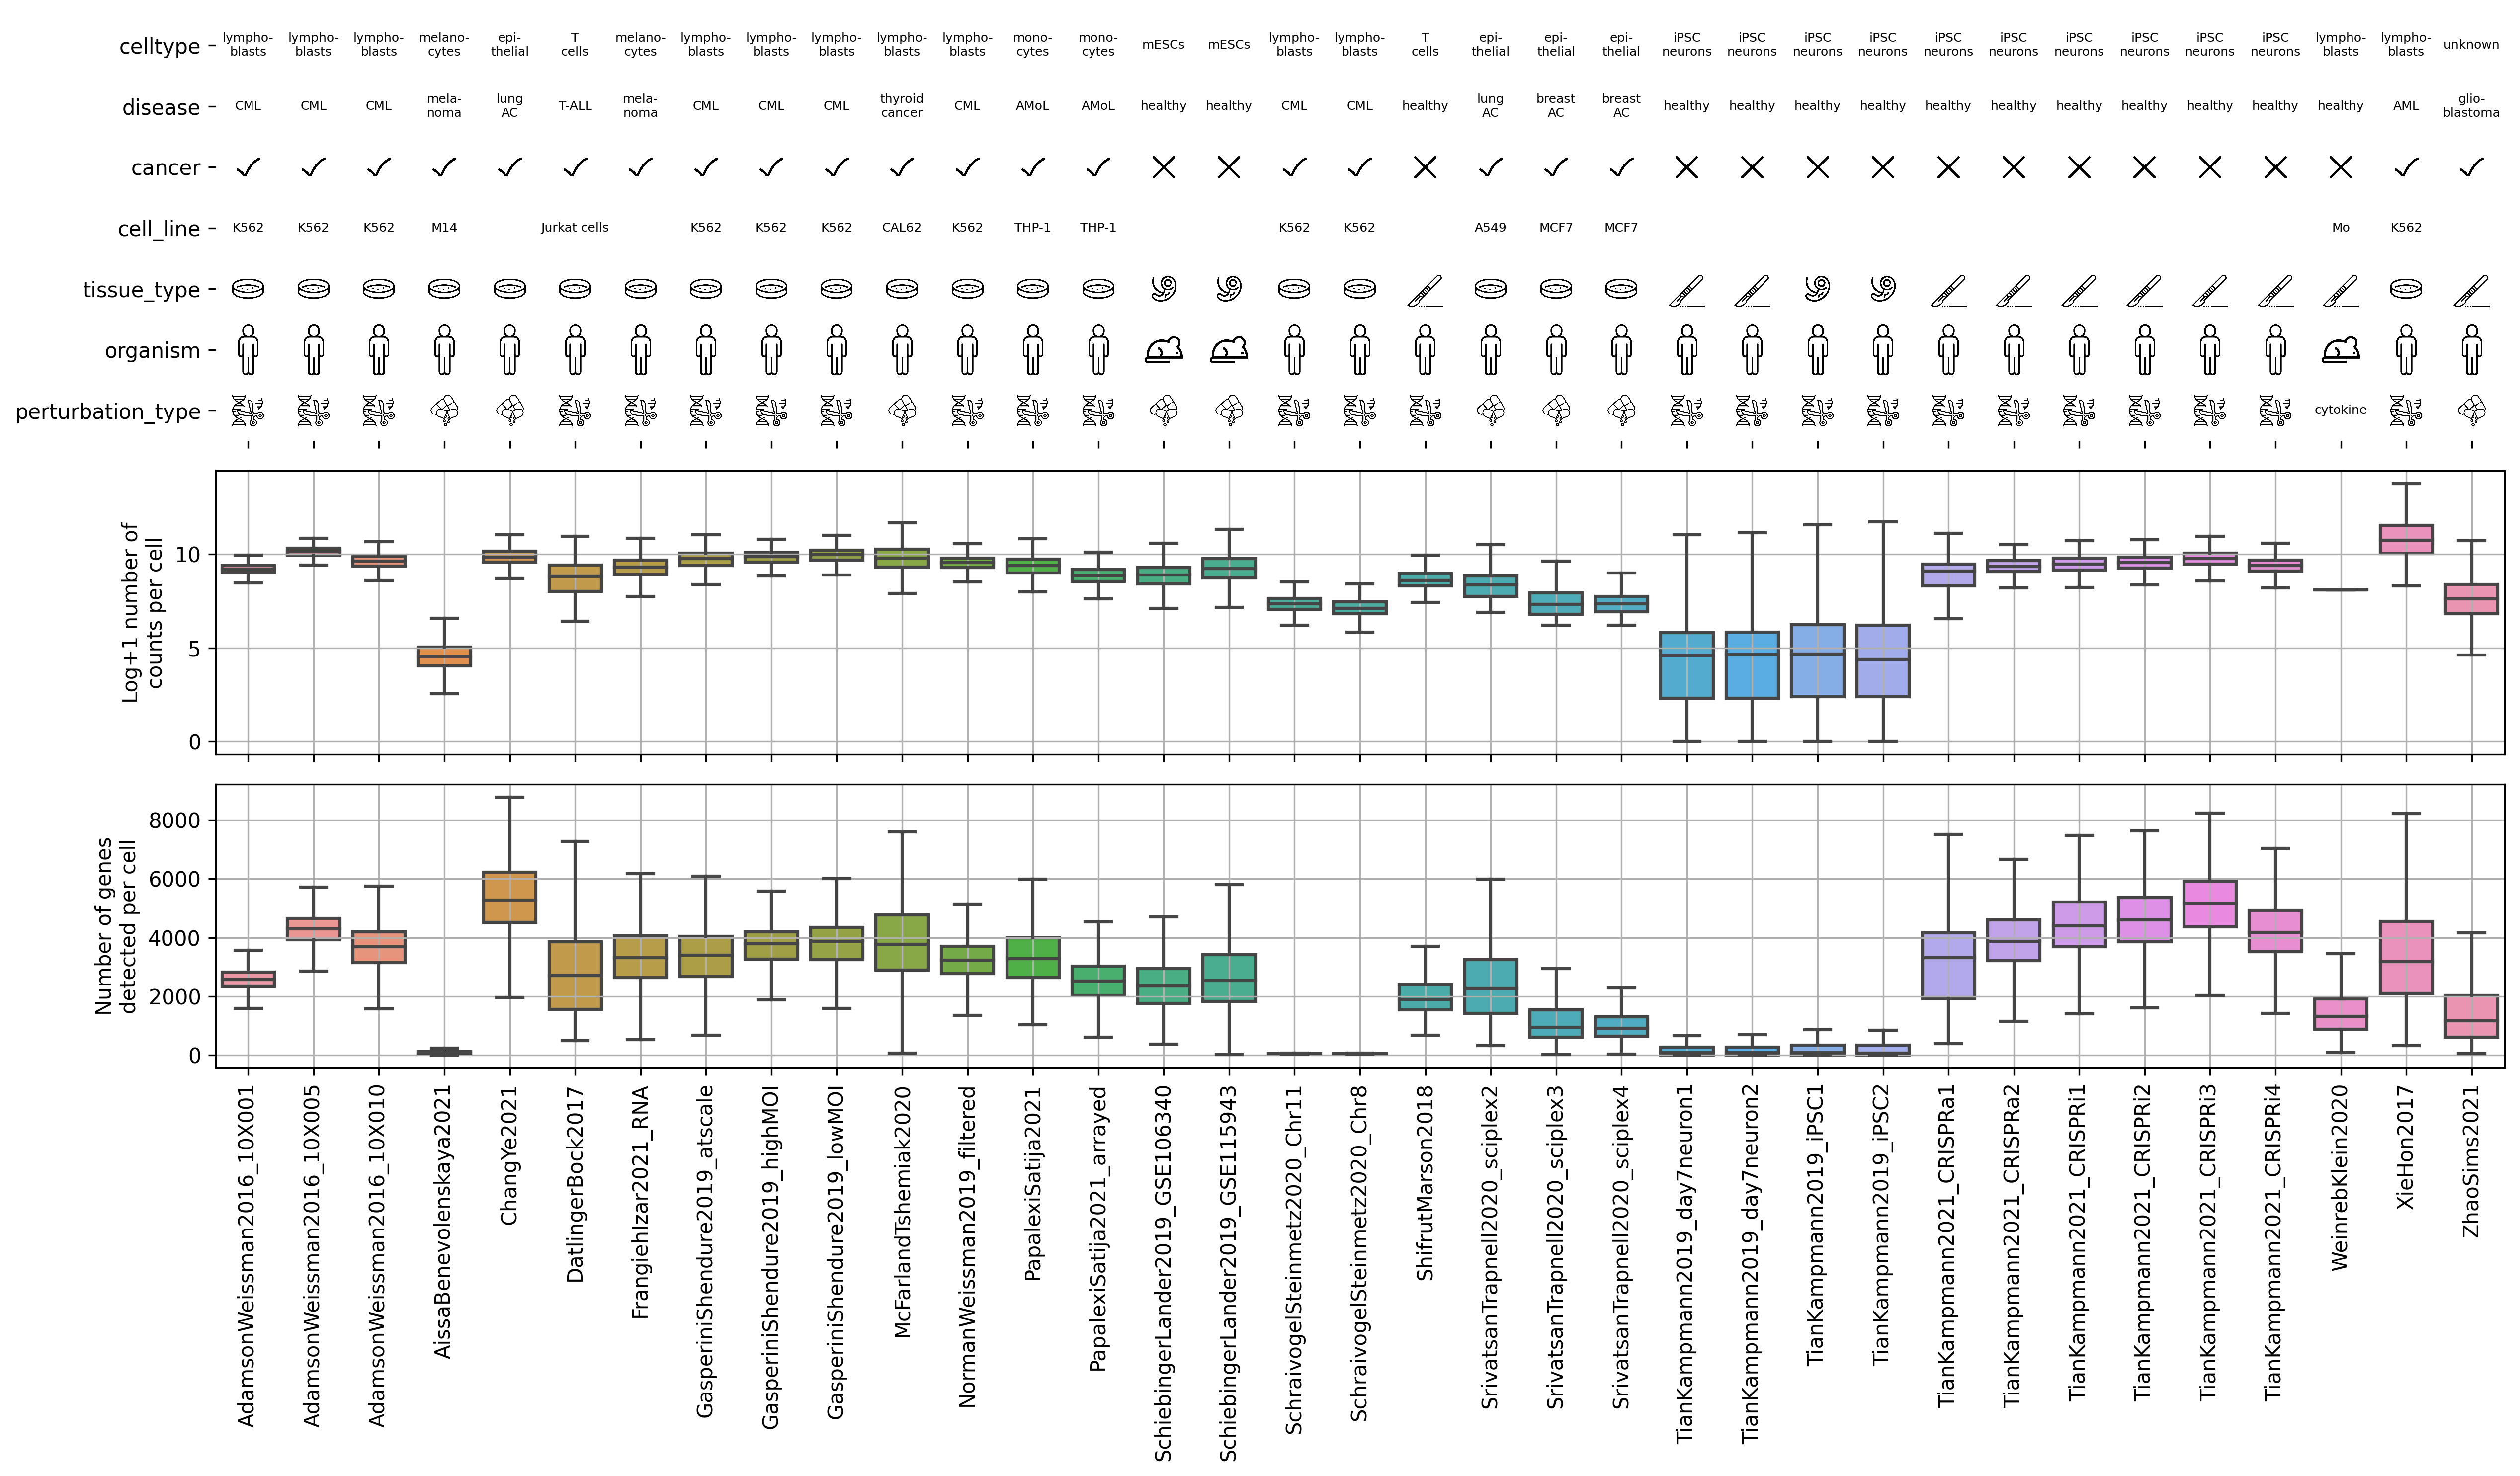

In [106]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

n = len(B.index)
m = len(B.columns)

# setup figure
# with sns.axes_style("whitegrid"):
fig, axs = pl.subplots(3, 1, figsize=[17, 10], sharex=True, dpi=300, gridspec_kw={'height_ratios': [1.5, 1, 1]})
# fig, ax = pl.subplots(figsize=[17,5], dpi=300)
text_options = {'fontsize': 6, 'ha': 'center', 'va': 'center'}

zoom_factor=0.6
mouse = OffsetImage(mpimg.imread('icons/mouse.png'), zoom=0.06*zoom_factor)
stem = OffsetImage(mpimg.imread('icons/stem.png'), zoom=0.04*zoom_factor)
human = OffsetImage(mpimg.imread('icons/person-standing.png'), zoom=0.08*zoom_factor)
primary = OffsetImage(mpimg.imread('icons/scalpel.png'), zoom=0.06*zoom_factor)
cell_line = OffsetImage(mpimg.imread('icons/petri-dish.png'), zoom=0.05*zoom_factor)
CRISPR = OffsetImage(mpimg.imread('icons/gene.png'), zoom=0.05*zoom_factor)
drug = OffsetImage(mpimg.imread('icons/pills.png'), zoom=0.05*zoom_factor)
True_ = OffsetImage(mpimg.imread('icons/check.png'), zoom=0.04*zoom_factor)
False_ = OffsetImage(mpimg.imread('icons/close.png'), zoom=0.035*zoom_factor)

ax = axs[0]

# perturbation_type
for i, (index, row) in enumerate(B.iterrows()):
    # ax.text(i, 0, row.perturbation_type, **text_options)
    if row.perturbation_type=='cytokine':
        ax.text(i, 0, row.perturbation_type.replace('_', ''), **text_options)
    else:
        ax.add_artist(AnnotationBbox(eval(row.perturbation_type), (i, 0), frameon=False))
    
    ax.add_artist(AnnotationBbox(eval(row.organism), (i, 1), frameon=False))
    # ax.text(i, 2, row.tissue_type.replace('_', ''), **text_options)
    ax.add_artist(AnnotationBbox(eval(row.tissue_type), (i, 2), frameon=False))
    ax.text(i, 3, row.cell_line if row.cell_line!=None else '', **text_options)
    # ax.text(i, 4, 'yes' if row.cancer==True else 'no', **text_options)
    ax.add_artist(AnnotationBbox(eval(str(row.cancer)+'_'), (i, 4), frameon=False))
    ax.text(i, 5, row.disease.replace(' ', '\n'), **text_options)
    ax.text(i, 6, row.celltype.replace(' ', '\n') if row.celltype!=None else None, **text_options)

ax.set_xlim([-0.5, n-0.5])
ax.set_ylim([-0.5, m-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.get_xaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(m))
ax.set_xticklabels(B.index, rotation=90)
ax.set_yticklabels(B.columns)
ax.grid(False)

dataset_names = B.index

# numerical vectors
num_obs_keys = ['ncounts', 'ngenes']  # numerical vector  # percent_ribo, percent_mito
o_name = ['Log+1 number of\ncounts per cell', 'Number of genes\ndetected per cell']#, 'Percentage of counts\nfrom mitochondrial genes']
num_data = []
for obs_key in num_obs_keys:
    num_data.append([obs[obs_key].values for obs in obses.values()])
for ax, dat, obs_key, name in zip(axs[1:], num_data, num_obs_keys, o_name):
    if obs_key=='ncounts':
        dat = [np.log1p(d) for d in dat]
    sns.boxplot(data=dat, showfliers=False, ax=ax, zorder=5)
    ax.set_ylabel(name)
    ax.grid()
    # ax.set_yscale('log')
# xticks and labels
axs[-1].set_xticks(np.arange(len(dataset_names)))
axs[-1].set_xticklabels(dataset_names, rotation=90)
pl.tight_layout()
pl.savefig('../../figures/dataset_overview_all.pdf', bbox_inches='tight')
pl.show()

In [60]:
pd.DataFrame(dats, index=['n_cells', 'n_genes', 'n_perturbations', 'is_cancer', 'organism', 'celltype', 'tissue_type', 
                          'perturbation_type', 'disease', 'dim_pca_005', 'dim_pca_001', 'dim_pca_0005']).T

,n_cells,n_genes,n_perturbations,is_cancer,organism,celltype,tissue_type,perturbation_type,disease,dim_pca_005,dim_pca_001,dim_pca_0005
GSE119450,52236,33694,49,False,human,T cells,primary,CRISPR,healthy,2,6,8
GSE135497_TAP_SCREEN__chromosome_11_screen,120310,3185,3105,True,human,lymphoblasts,cell_line,CRISPR,chronic myelogenous leukemia,2,3,3
GSE135497_TAP_SCREEN__chromosome_8_screen,112260,4191,4115,True,human,lymphoblasts,cell_line,CRISPR,chronic myelogenous leukemia,1,2,2
GSE140802,65075,25289,5,False,mouse,Mo,primary,cytokine,healthy,3,9,14
GSE148842,165748,60725,7,True,human,unknown,primary,drug,glioblastoma,3,12,17
GSE168620_scifi2,39194,25904,48,True,human,T cells,cell_line,CRISPR,acute T cell leukemia,1,3,5
GSE90546_GSM2406675_10X001,5768,35635,10,True,human,lymphoblasts,cell_line,CRISPR,chronic myelogenous leukemia,2,6,10
GSE90546_GSM2406677_10X005,15006,32738,21,True,human,lymphoblasts,cell_line,CRISPR,chronic myelogenous leukemia,2,8,12
GSE90546_GSM2406681_10X010,65337,32738,115,True,human,lymphoblasts,cell_line,CRISPR,chronic myelogenous leukemia,2,8,12
GSE92872,5905,36722,97,True,human,T cells,cell_line,CRISPR,acute T cell leukemia,3,5,9


## relative plots (e.g. scatter)

In [52]:
tab = pd.DataFrame(index=obses.keys())
for name, obs in obses.items():
    # print(name)
    tab.loc[name, 'mean counts per cell'] = np.mean(obs.ncounts)
    tab.loc[name, 'mean genes expressed per cell'] = np.mean(obs.ngenes)
    tab.loc[name, 'number of perturbations'] = len(pd.unique(obs.perturbation))
    tab.loc[name, 'number of perturbations (log)'] = np.log(len(pd.unique(obs.perturbation)))
    tab.loc[name, 'number of cells'] = len(obs)
    tab.loc[name, 'mean number of cells per perturbation'] = np.mean(obs.value_counts('perturbation'))
    tab.loc[name, 'modality'] = 'protein' if 'protein' in name else 'RNA'
    sname = name.split('_')[0]
    sname = 'McFarlandTsherniak2020' if 'McFarland' in sname else sname
    tab.loc[name, 'year'] = int(sname[-4:])
    tab.loc[name, 'Date of Submission'] = pd.to_datetime(metadata.loc[sname, 'Date of Submission'])
    for cat_key in ['tissue_type', 'cancer', 'organism', 'perturbation_type']:
        tab.loc[name, cat_key] = pd.unique(obs[cat_key])[0] if cat_key in obs.keys() else None
    tab.loc[name, 'dataset'] = name

tab['perturbation_type'][tab.perturbation_type=='CRISPR'] = 'CRISPR-cas9'
tab.loc['TianKampmann2021_CRISPRa', 'perturbation_type'] = 'CRISPRa'
tab.loc['TianKampmann2021_CRISPRi', 'perturbation_type'] = 'CRISPRi'
tab.loc['TianKampmann2019_iPSC', 'perturbation_type'] = 'CRISPRi'
tab.loc['TianKampmann2019_day7neuron', 'perturbation_type'] = 'CRISPRi'
tab

,mean counts per cell,mean genes expressed per cell,number of perturbations,number of perturbations (log),number of cells,mean number of cells per perturbation,modality,year,Date of Submission,tissue_type,cancer,organism,perturbation_type,dataset
AdamsonWeissman2016_GSM2406675_10X001,10166.141817,2557.463592,10.0,2.302585,5768.0,639.777778,RNA,2016.0,2019-10-01,cell_line,True,human,CRISPR,AdamsonWeissman2016_GSM2406675_10X001
AdamsonWeissman2016_GSM2406677_10X005,25340.052512,4235.199187,21.0,3.044522,15006.0,735.500000,RNA,2016.0,2019-10-01,cell_line,True,human,CRISPR,AdamsonWeissman2016_GSM2406677_10X005
AdamsonWeissman2016_GSM2406681_10X010,15915.297580,3639.789813,115.0,4.744932,65337.0,550.210526,RNA,2016.0,2019-10-01,cell_line,True,human,CRISPR,AdamsonWeissman2016_GSM2406681_10X010
ChangYe2021,22044.779573,5439.283629,4.0,1.386294,42277.0,10569.250000,RNA,2021.0,2021-08-01,None,True,human,drug,ChangYe2021
DatlingerBock2017,8567.240982,2789.345470,97.0,4.574711,5905.0,60.876289,RNA,2017.0,2016-12-01,cell_line,True,human,CRISPR,DatlingerBock2017
DatlingerBock2021,957.881436,273.351508,48.0,3.871201,39194.0,816.541667,RNA,2021.0,2019-12-01,cell_line,True,human,CRISPR,DatlingerBock2021
FrangiehIzar2021_RNA,12700.372815,3392.721345,249.0,5.517453,218331.0,876.831325,RNA,2021.0,2020-08-01,cell_line_co-culture,True,human,CRISPR,FrangiehIzar2021_RNA
GasperiniShendure2019_atscale,18171.176834,3371.526268,203496.0,12.223402,207324.0,1.011312,RNA,2019.0,2018-06-01,cell_line,True,human,CRISPR,GasperiniShendure2019_atscale
GasperiniShendure2019_highMOI,19305.300147,3675.874334,39088.0,10.573571,47650.0,1.211426,RNA,2019.0,2018-06-01,cell_line,True,human,CRISPR,GasperiniShendure2019_highMOI
GasperiniShendure2019_lowMOI,22108.307698,3755.207175,16532.0,9.713053,41284.0,2.226786,RNA,2019.0,2018-06-01,cell_line,True,human,CRISPR,GasperiniShendure2019_lowMOI


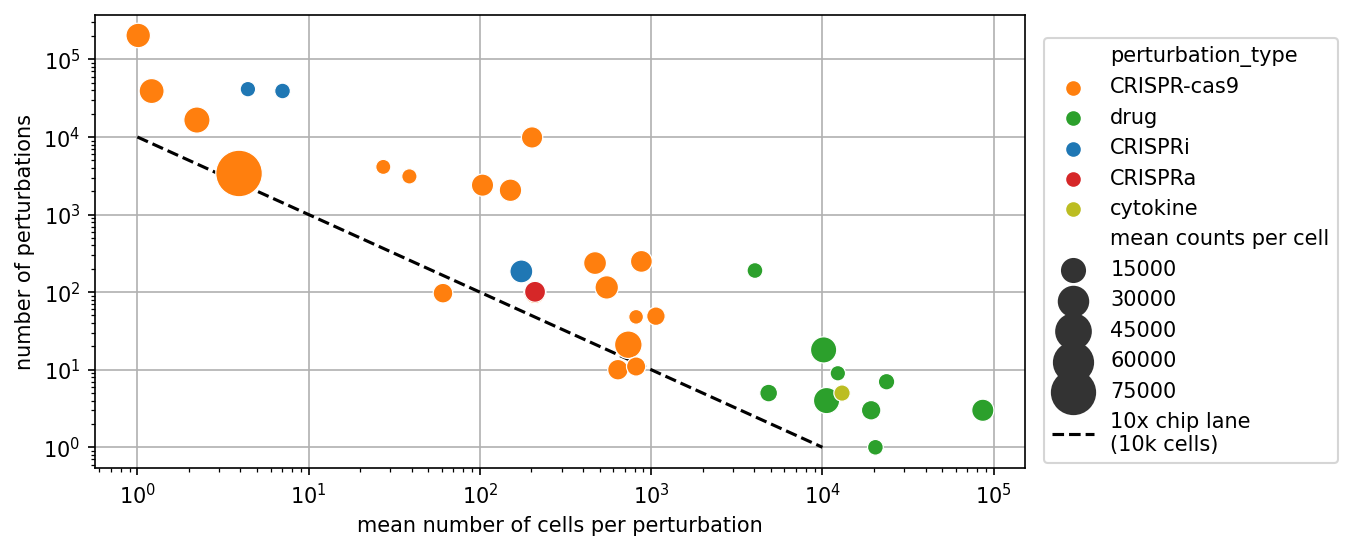

In [100]:
fig, ax = pl.subplots(figsize=[8,4], dpi=150)
sns.scatterplot(data=tab, x='mean number of cells per perturbation', y='number of perturbations', palette=colors_perturbation_types,
                hue='perturbation_type', size='mean counts per cell', sizes=(50,500), zorder=3)
ax.plot([1, 1e4], [1e4, 1], 'k--', label='10x chip lane\n(10k cells)')
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.xscale('log')
pl.yscale('log')
ax.grid(which='major', zorder=-1)
# pl.title('Trade-off between number of perturbations and\nmean cells per perturbation')
pl.savefig('../../figures/dataset_comparison_perturbation_quality_vs_quantity.pdf', bbox_inches='tight')
pl.show()

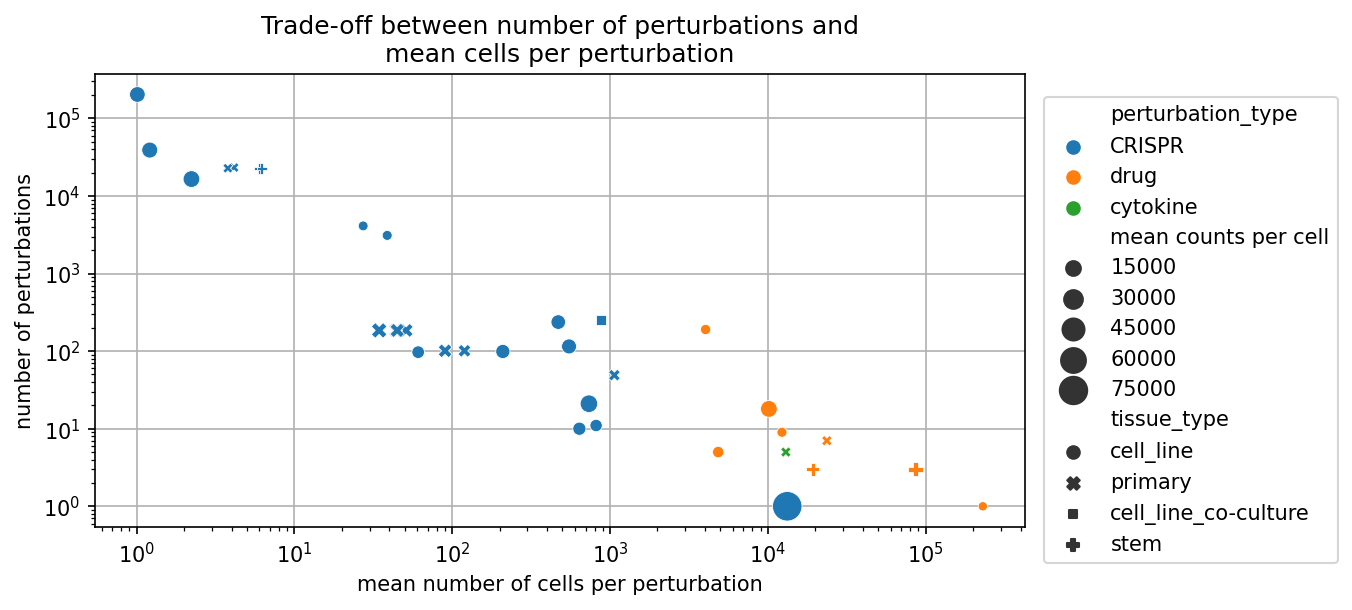

In [196]:
fig, ax = pl.subplots(figsize=[8,4], dpi=150)
sns.scatterplot(data=tab, x='mean number of cells per perturbation', y='number of perturbations', 
                hue='perturbation_type', style='tissue_type', size='mean counts per cell', sizes=(20,200), zorder=3)
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.xscale('log')
pl.yscale('log')
ax.grid(which='major', zorder=-1)
pl.title('Trade-off between number of perturbations and\nmean cells per perturbation')
pl.savefig('../../figures/dataset_comparison_perturbation_quality_vs_quantity.pdf', bbox_inches='tight')
pl.show()

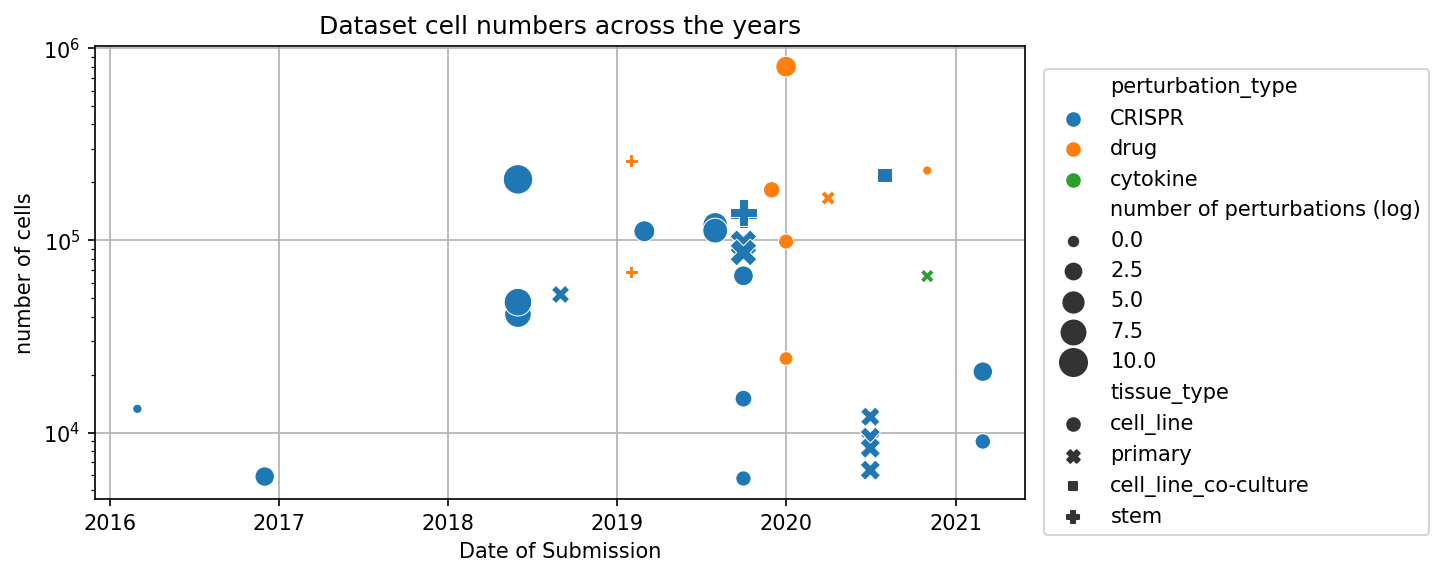

In [197]:
fig, ax = pl.subplots(figsize=[8,4], dpi=150)
sns.scatterplot(data=tab, x='Date of Submission', y='number of cells', hue='perturbation_type', style='tissue_type', size='number of perturbations (log)', sizes=(20,200), ax=ax, zorder=3)
# pl.xscale('log')
pl.yscale('log')
ax.grid(which='major', zorder=-1)
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.title('Dataset cell numbers across the years')
pl.savefig('../../figures/dataset_comparison_cellnumbers_over_the_years.pdf', bbox_inches='tight')
pl.show()

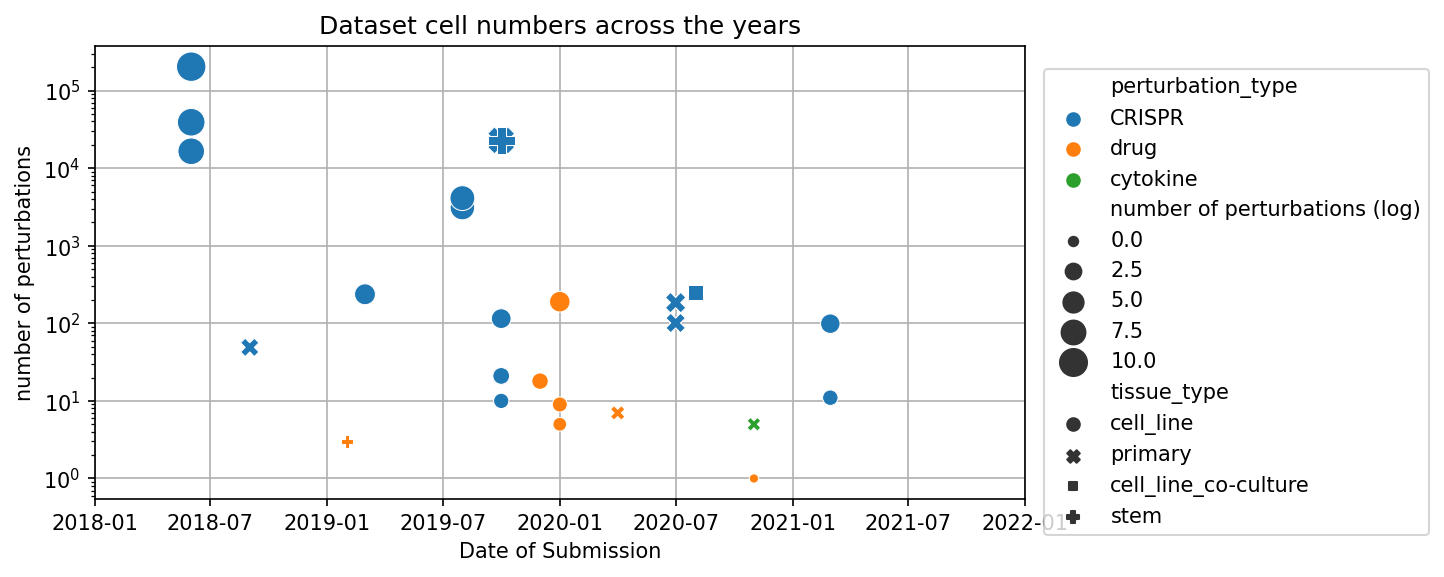

In [227]:
fig, ax = pl.subplots(figsize=[8,4], dpi=150)
sns.scatterplot(data=tab, x='Date of Submission', y='number of perturbations', 
                hue='perturbation_type', style='tissue_type', size='number of perturbations (log)', 
                sizes=(20,200), ax=ax, zorder=3)
# pl.xscale('log')
pl.yscale('log')
ax.grid(which='major', zorder=-1)
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.title('Dataset cell numbers across the years')
pl.xlim(pd.to_datetime(['2018', '2022']))
pl.savefig('../../figures/dataset_comparison_numberofperts_over_the_years_2018_2022.pdf', bbox_inches='tight')
pl.show()

# Gene-wise metadata (Var)

- number of counts across all cells
- number of cells where gene is expressed (i.e. count>0)
- dispersion?
- chromosome? / contig?
- is gene mitochondrial

In [15]:
# TODO fix these datasets!
# delete datasets from obses where the column 'ncounts' is missing
K = list(vares.keys())
for name in K:
    if 'ncounts' not in vares[name].columns:
        print(name)
        del vares[name]

AissaBenevolenskaya2021
DixitRegev2016


In [19]:
vares = {key: vares[key] for key in np.sort(list(vares.keys()))}  # sort 

In [20]:
num_var_keys = ['ncounts', 'ncells']  # numerical vector
num_data = []
for var_key in num_var_keys:
    num_data.append([var[var_key].values for name, var in vares.items()])
    
# for obs_key in num_obs_keys:
ddict = {name: var[num_var_keys] for name, var in vares.items()}
df = pd.concat(ddict).reset_index(level=0)
df.columns = ['dataset'] + num_var_keys

In [22]:
cpalette = {d: colors_perturbation_types[B.loc[d, 'perturbation_type']] for d in vares.keys()}

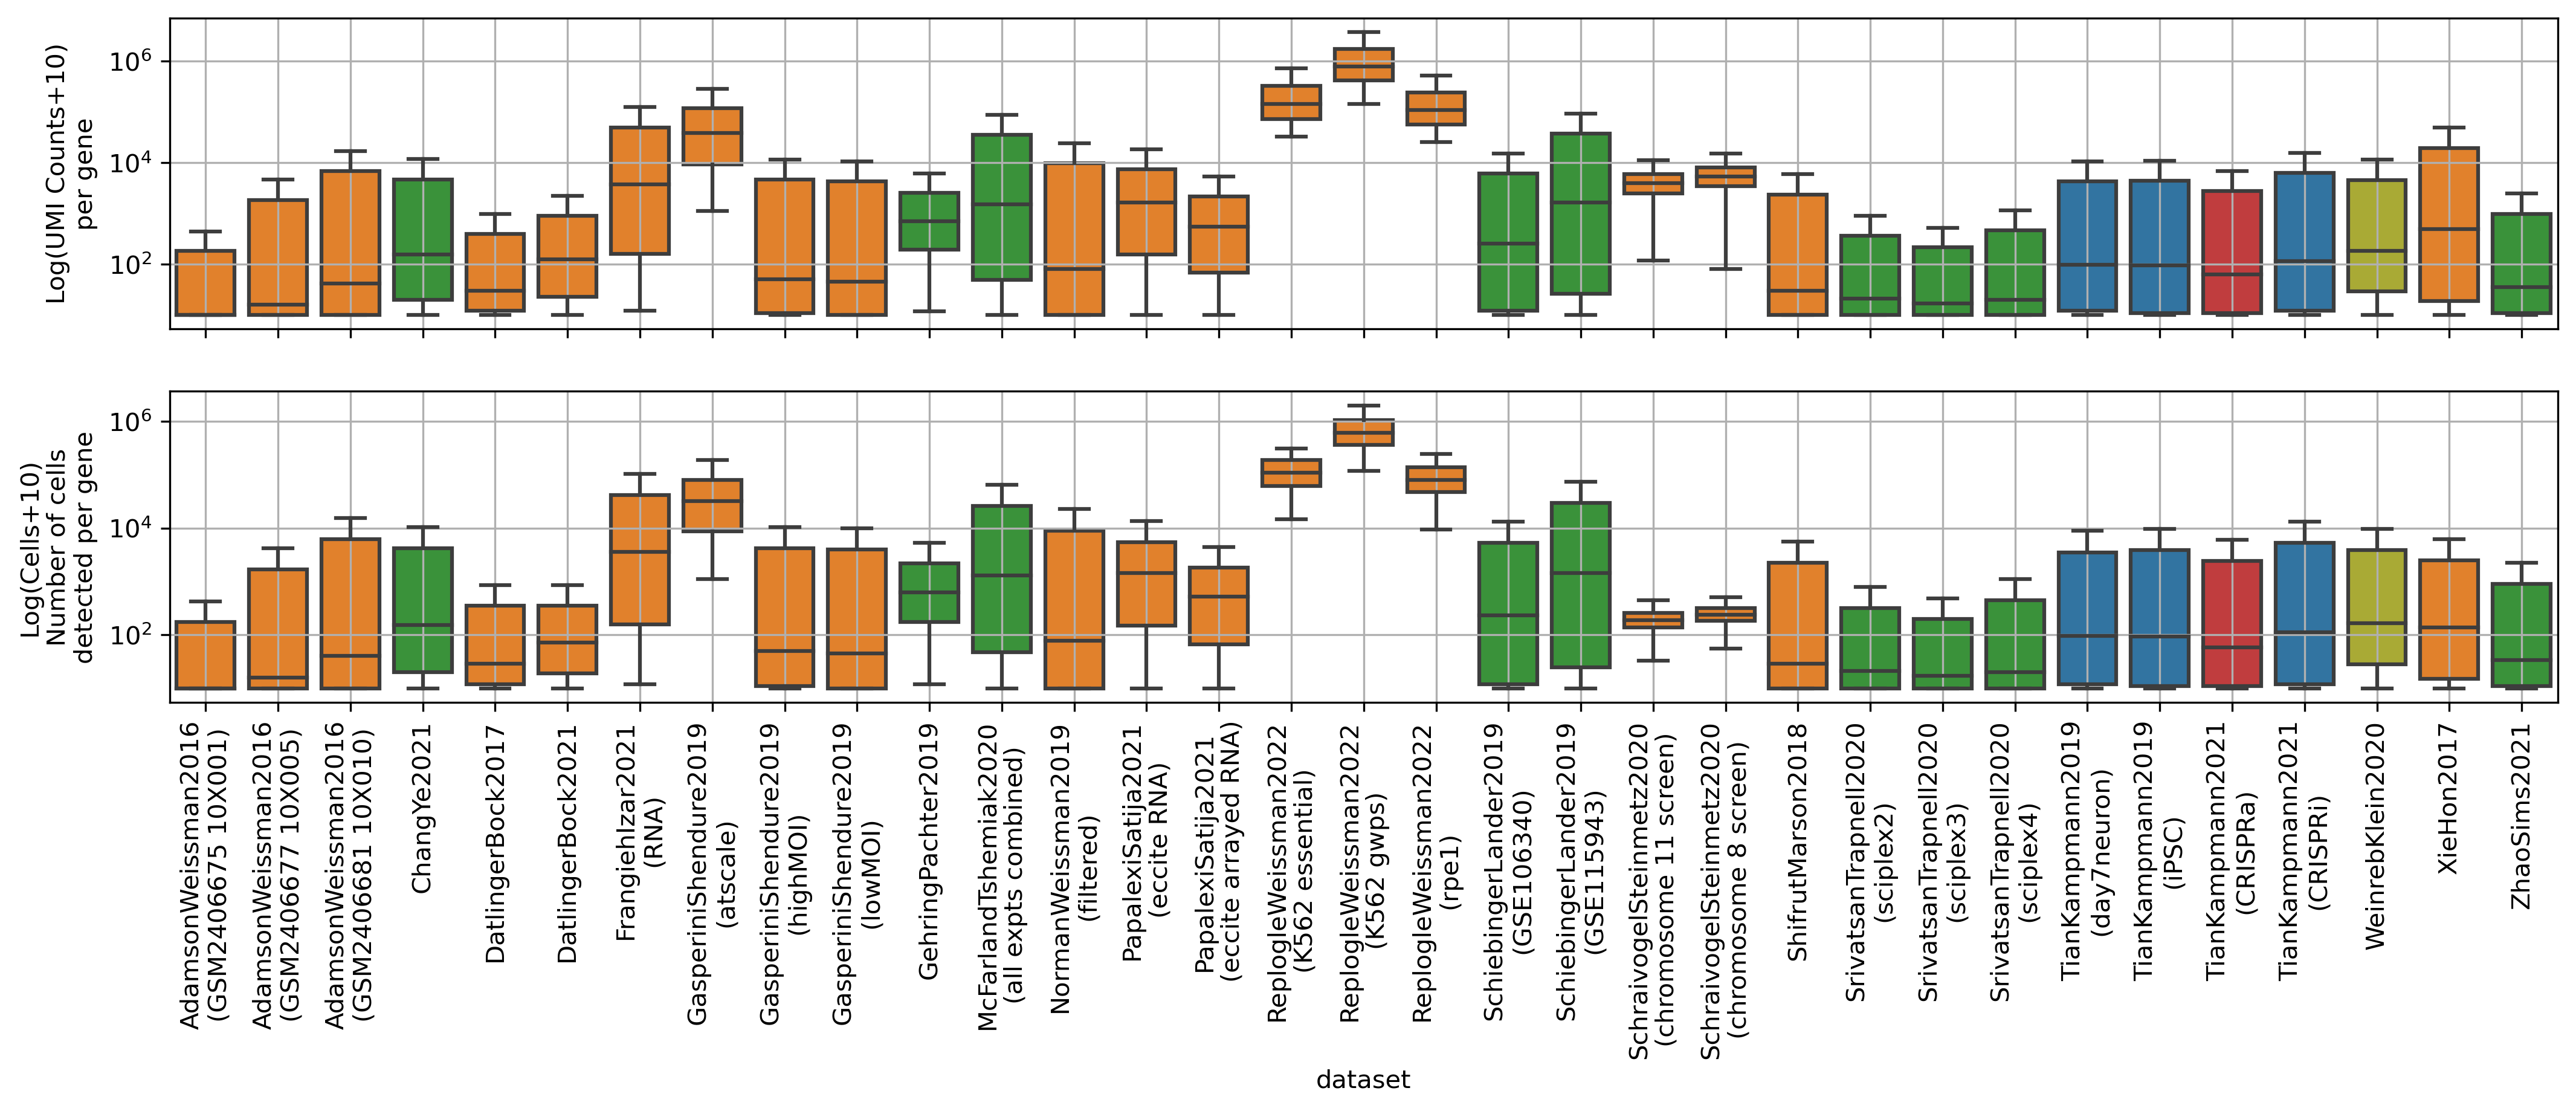

In [23]:
# options
color = 'perturbation_type'  #'tab:blue'
palette = cpalette
pseudocounts = 10

# setup figure
# with sns.axes_style("whitegrid"):
fig, axs = pl.subplots(2, 1, figsize=[17, 5], sharex=True, dpi=300)

# First row ncounts
ax = axs[0]
df['ncounts'] += pseudocounts
sns.boxplot(data=df, x='dataset', y='ncounts', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_ylabel(f'Log(UMI Counts+{pseudocounts})\nper gene')
ax.set_yscale('log')
ax.grid()

# Second row ngenes
ax = axs[1]
df['ncells'] += pseudocounts
sns.boxplot(data=df, x='dataset', y='ncells', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_ylabel(f'Log(Cells+{pseudocounts})\nNumber of cells\ndetected per gene')
ax.set_yscale('log')
ax.grid()
    
# xticks and labels
dataset_names = vares.keys()
dataset_names = [x.replace('TAP_SCREEN__', '') for x in dataset_names]
dataset_names = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in dataset_names]
dataset_names = [x.replace('_', ' ') for x in dataset_names]
axs[-1].set_xticks(np.arange(len(dataset_names)))
axs[0].set_xlabel('')
axs[-1].set_xticklabels(dataset_names, rotation=90)
pl.savefig('../../figures/dataset_overview_boxplots_horizontal_geneqc.pdf', bbox_inches='tight')
pl.show()

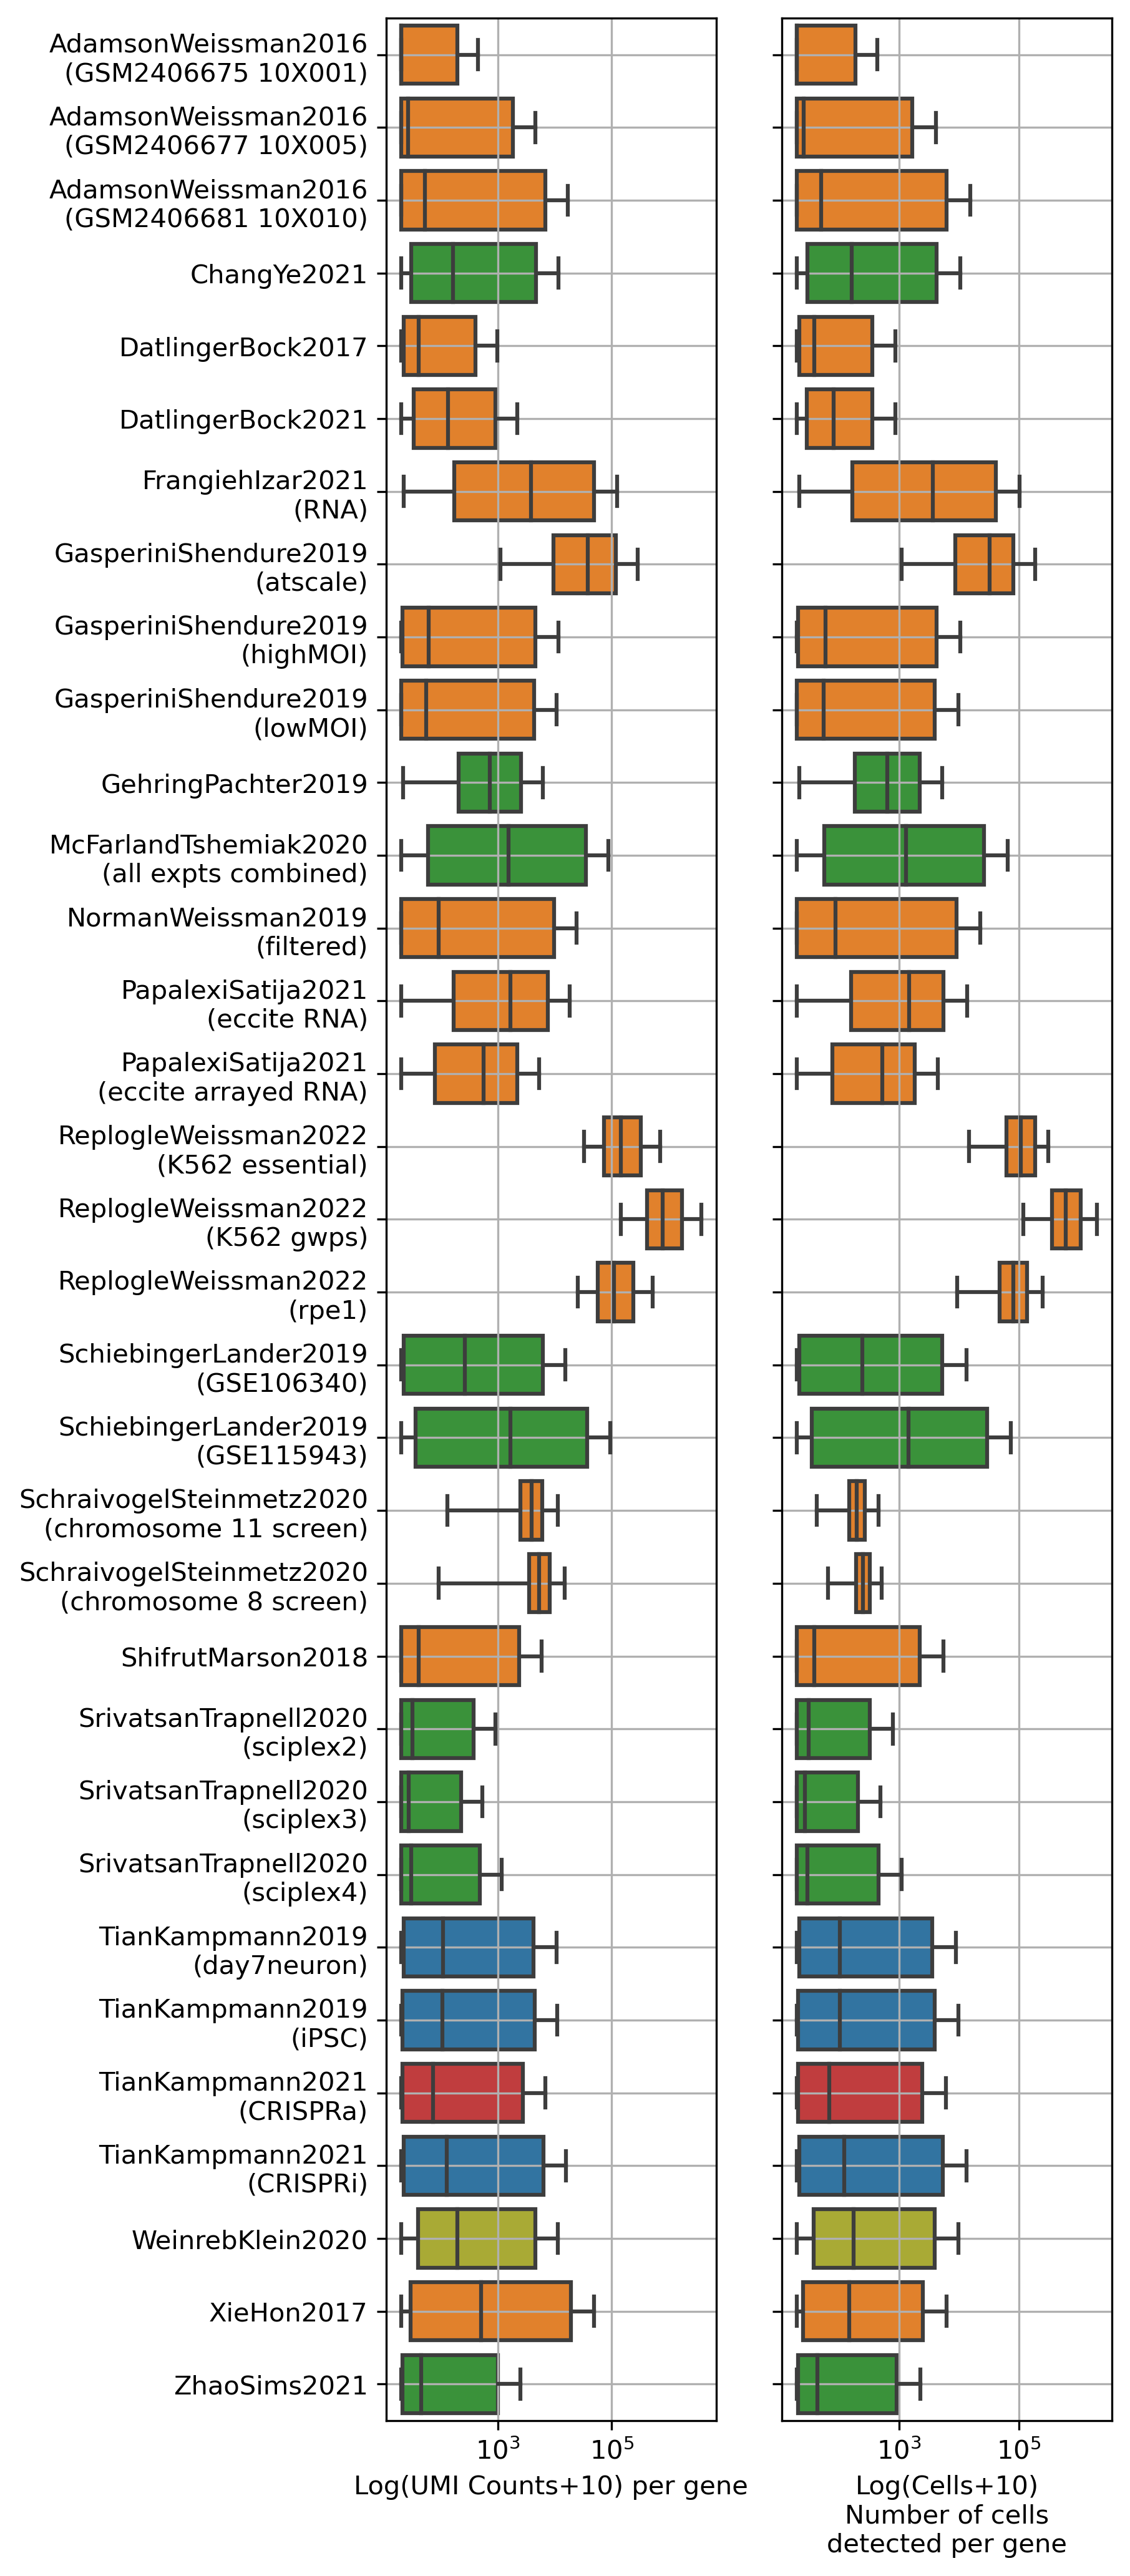

In [24]:
# options
color = 'perturbation_type'  #'tab:blue'
palette = cpalette
pseudocounts = 10

# setup figure
# with sns.axes_style("whitegrid"):
fig, axs = pl.subplots(1, 2, figsize=[5, 17], sharey=True, dpi=300)

# First row ncounts
ax = axs[0]
df['ncounts'] += pseudocounts
sns.boxplot(data=df, y='dataset', x='ncounts', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel(f'Log(UMI Counts+{pseudocounts}) per gene')
ax.set_xscale('log')
# ax.set_title('UMI Counts')
ax.grid()

# Second row ngenes
ax = axs[1]
df['ncells'] += pseudocounts
sns.boxplot(data=df, y='dataset', x='ncells', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel(f'Log(Cells+{pseudocounts})\nNumber of cells\ndetected per gene')
ax.set_xscale('log')
# ax.set_title('Genes Expressed')
ax.grid()
    
# xticks and labels
dataset_names = vares.keys()
dataset_names = [x.replace('TAP_SCREEN__', '') for x in dataset_names]
dataset_names = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in dataset_names]
dataset_names = [x.replace('_', ' ') for x in dataset_names]
axs[-1].set_yticks(np.arange(len(dataset_names)))
axs[-1].set_ylabel('')
axs[-1].set_yticklabels(dataset_names, rotation=90)
axs[0].set_ylabel('')
pl.savefig('../../figures/dataset_overview_boxplots_vertical_geneqc.pdf', bbox_inches='tight')
pl.show()

# TODOs

- for each dataset, unify the different obs given. E.g. condition, time, donor, tissue type / cell line
- estimate intrinsic dimension (PCA, scikit-dimension)
- Augur
- MELD
- MUSIC
- scrublet for similar for doublet detection
- SoupX or cellbender against ambient mRNA
- annotation
    - cell cycle
    - common signatures (Hallmarks?)

In [23]:
import scrublet as scr
scrub = scr.Scrublet(adatas['GSE119450_GSE119450D1_NoStim'].X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.0%
Elapsed time: 13.3 seconds


In [25]:
np.sum(predicted_doublets)

3